# prepare data

this notebook:

- extracts profiles from apk/dm files 
- runs profdump on the profiles
- transforms the profiles to json files we can use

and also:
- runs some metadata analysis on apks to grab i.a. the total number of dex methods and activities

while doing all of this cached based on file contents, so we don't analyze the same file twice

In [1]:
import json
import re
from pathlib import Path
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sh
import glob
from multiprocessing import Pool


import analysishelper as ah
import cachedefs as cd

In [2]:
# first test with the sample day apps
pool = Pool(processes=8)
for _ in tqdm.tqdm(pool.imap_unordered(ah.cached_apk_to_metadata, ah.sample_day_dirs(False)), total=len(ah.sample_day_dirs(False))):
    pass

 17%|█▋        | 143/844 [00:02<00:14, 48.36it/s]

 45%|████▍     | 379/844 [00:11<00:23, 19.67it/s]

error analyzing com.turborocketgames.wildcraft


 57%|█████▋    | 485/844 [00:16<00:22, 15.79it/s]

error analyzing com.gismart.realpianofree


 60%|█████▉    | 504/844 [00:18<00:33, 10.26it/s]

error analyzing com.arcsys.tictactoe


 68%|██████▊   | 572/844 [00:25<00:34,  7.91it/s]

error analyzing in.mohalla.video


 73%|███████▎  | 619/844 [00:38<00:33,  6.71it/s]

error analyzing in.sweatco.app


 75%|███████▌  | 635/844 [00:39<00:16, 12.72it/s]

error analyzing com.gismart.guitar


 83%|████████▎ | 703/844 [00:42<00:06, 22.43it/s]

error analyzing in.swiggy.android


 85%|████████▍ | 714/844 [00:43<00:12, 10.72it/s]

error analyzing com.sbi.lotusintouch


 88%|████████▊ | 742/844 [00:53<00:12,  8.44it/s]

error analyzing ru.rostel


 91%|█████████ | 764/844 [01:03<00:10,  7.80it/s]

error analyzing com.audible.application


 99%|█████████▉| 838/844 [01:07<00:00, 24.11it/s]

error analyzing in.mohalla.sharechat


 99%|█████████▉| 838/844 [01:19<00:00, 24.11it/s]

error analyzing net.mbc.shahid


100%|█████████▉| 840/844 [01:27<00:07,  1.99s/it]

error analyzing com.miui.player


100%|█████████▉| 841/844 [02:07<00:20,  6.74s/it]

error analyzing com.bitsmedia.android.muslimpro


100%|█████████▉| 842/844 [02:55<00:26, 13.13s/it]

error analyzing com.paypal.android.p2pmobile


100%|█████████▉| 843/844 [16:35<02:37, 157.65s/it]

error analyzing com.picpay


100%|██████████| 844/844 [48:47<00:00,  3.47s/it] 


In [3]:
# extract profiles 

pool = Pool(processes=1)
#for i in tqdm.tqdm(pool.imap_unordered(
#            ah.cached_extract_baseline_and_cloud_prof,
#            ah.sample_day_dirs(False)
#        ), total=len(ah.sample_day_dirs(False))):
#    pass

for i in tqdm.tqdm(ah.sample_day_dirs(False)):
    ah.cached_extract_baseline_and_cloud_prof(i)

100%|██████████| 844/844 [00:00<00:00, 51234.44it/s]


In [4]:
# prepare profiles runs profman to generate profdump files
def do_prepare_both_profiles(apkdir):
    ah.cached_get_profdump_path(apkdir, cloud=False)
    ah.cached_get_profdump_path(apkdir, cloud=True)

for i in tqdm.tqdm(ah.sample_day_dirs(False)):
    do_prepare_both_profiles(i)

100%|██████████| 844/844 [00:15<00:00, 54.85it/s]


In [ ]:
# now we parse the profdump and save the result as json for easy import
for apkdir in tqdm.tqdm(ah.sample_day_dirs()):
    ah.cached_profile_txt_to_json(apkdir, cloud=False)
    ah.cached_profile_txt_to_json(apkdir, cloud=True)

100%|██████████| 844/844 [00:44<00:00, 18.94it/s]


we have data, now we transform it into something usable

In [2]:
def get_sample_profiles_json():

    if cd.CACHE_SAMPLE_PROFILES_JSON_PATH.exists():
        print("found cache, reading that")
        with open(cd.CACHE_SAMPLE_PROFILES_JSON_PATH, "r") as f:
            return json.load(f)

    sample_profiles_json = {}

    for apkdir in tqdm.tqdm(ah.sample_day_dirs()):
        _, apkid = ah.get_date_apkid(apkdir)
        basejson = ah.cached_profile_txt_to_json(apkdir, cloud=False)
        clodjson = ah.cached_profile_txt_to_json(apkdir, cloud=True)

        sample_profiles_json[apkid] = {}
        
        sample_profiles_json[apkid]["baseline"] = basejson if basejson else {}
        sample_profiles_json[apkid]["cloud"] = clodjson if clodjson else {}
    
    with open(cd.CACHE_SAMPLE_PROFILES_JSON_PATH, "w") as f:
        json.dump(sample_profiles_json, f)
    
    return sample_profiles_json

sample_profiles_json = get_sample_profiles_json()



found cache, reading that


In [4]:
len(sample_profiles_json['com.bitstrips.imoji']['baseline']['1']['hot'])

#[appid: str]["baseline" or "cloud": str][dex_number: str]["hot" or "startup" or "post" or "classes": str][index into list of functions/classes: int]

360


- transformation, transformation now begins!
- we want a pandas frame with the following:
- 'id', shared_hot, shared_startup, shared_post,
   - base_only_hot, base_only_startup, base_only_post,
   - cloud_only_hot, cloud_only_startup, cloud_only_post

- because methods are indexed by the dex file, we use that dex number as offset
- (a dex file can have at most 65,536 methods), so we calculate a list of:
- 100,000*dex_number+method_number for each of the hot/startup/post methods
- we drop the classes for this analysis
- why numbers? to save space and make our live easier with numpy

In [8]:

def profdata_to_set(p):
    r = {'hot': set(), 'startup': set(), 'post': set()}
    _h, _s, _p = (0, 0, 0)
    for didx, v in p.items():
        intdidx = int(didx)
        if 'hot' in v.keys():
            for midx in v['hot']:
                r['hot'].add(100000*intdidx + int(midx)) # hack to differentiate method ids in dexes, since max ids per dex are ~65k
                _h+=1
        if 'startup' in v.keys():
            for midx in v['startup']:
                r['startup'].add(100000*intdidx + int(midx))
                _s+=1
        if 'post' in v.keys():
            for midx in v['post']:
                r['post'].add(100000*intdidx + int(midx))
                _p+=1
    # 'any' as a set of any of the above
    r['any'] = r['hot'].union(r['startup']).union(r['post'])
    assert(len(r['hot']) == _h)
    assert(len(r['startup']) == _s)
    assert(len(r['post']) == _p)
    assert(len(r['any']) <= _h+_s+_p)
    return r


def transform_data_to_sets(data):
    r = {}
    for app, v in tqdm.tqdm(data.items()):
        baseline = {'hot': set(), 'startup': set(), 'post': set(), 'any': set()}
        primary = {'hot': set(), 'startup': set(), 'post': set(), 'any': set()}
        if 'baseline' in v.keys():
            baseline = profdata_to_set(v['baseline'])

        if 'cloud' in v.keys():
            primary = profdata_to_set(v['cloud'])
        r[app] = {'baseline': baseline, 'cloud': primary}
    return r

def get_intersection_and_exclusive_baseline_cloud(v, mtype):
    bp = v['baseline'][mtype]
    cp = v['cloud'][mtype]
    ints = len(bp.intersection(cp)) # intersection
    ob = len(bp.difference(cp)) # only base
    oc = len(cp.difference(bp)) # only cloud
    return ints, ob, oc

def sets_to_instersections_exclusives(udata):
    ids = []
    r = []
    for appid, v in tqdm.tqdm(udata.items()):
        ids.append(appid)
        vals = {}
        for mtype in ['hot', 'startup', 'post', 'any']:
            ints, bo, co = get_intersection_and_exclusive_baseline_cloud(v, mtype)
            vals[f'shared_{mtype}'] = ints
            vals[f'baseline_only_{mtype}'] = bo
            vals[f'cloud_only_{mtype}'] = co
        r.append(vals)
    return ids, r

In [9]:
def create_plotable_dataframe_from_json(day_json):
    unified_data = transform_data_to_sets(day_json)

    appids, plotable_data = sets_to_instersections_exclusives(unified_data)

    return pd.DataFrame(plotable_data, index=appids)

if not cd.CACHE_SAMPLE_PROFILES_PLOTABLE.exists():
    print("computing plotable")
    df_plotable = create_plotable_dataframe_from_json(sample_profiles_json)
    df_plotable.to_pickle(cd.CACHE_SAMPLE_PROFILES_PLOTABLE)
else:
    print("reading plotable")
    df_plotable = pd.read_pickle(cd.CACHE_SAMPLE_PROFILES_PLOTABLE)

computing plotable


100%|██████████| 844/844 [00:03<00:00, 278.57it/s]


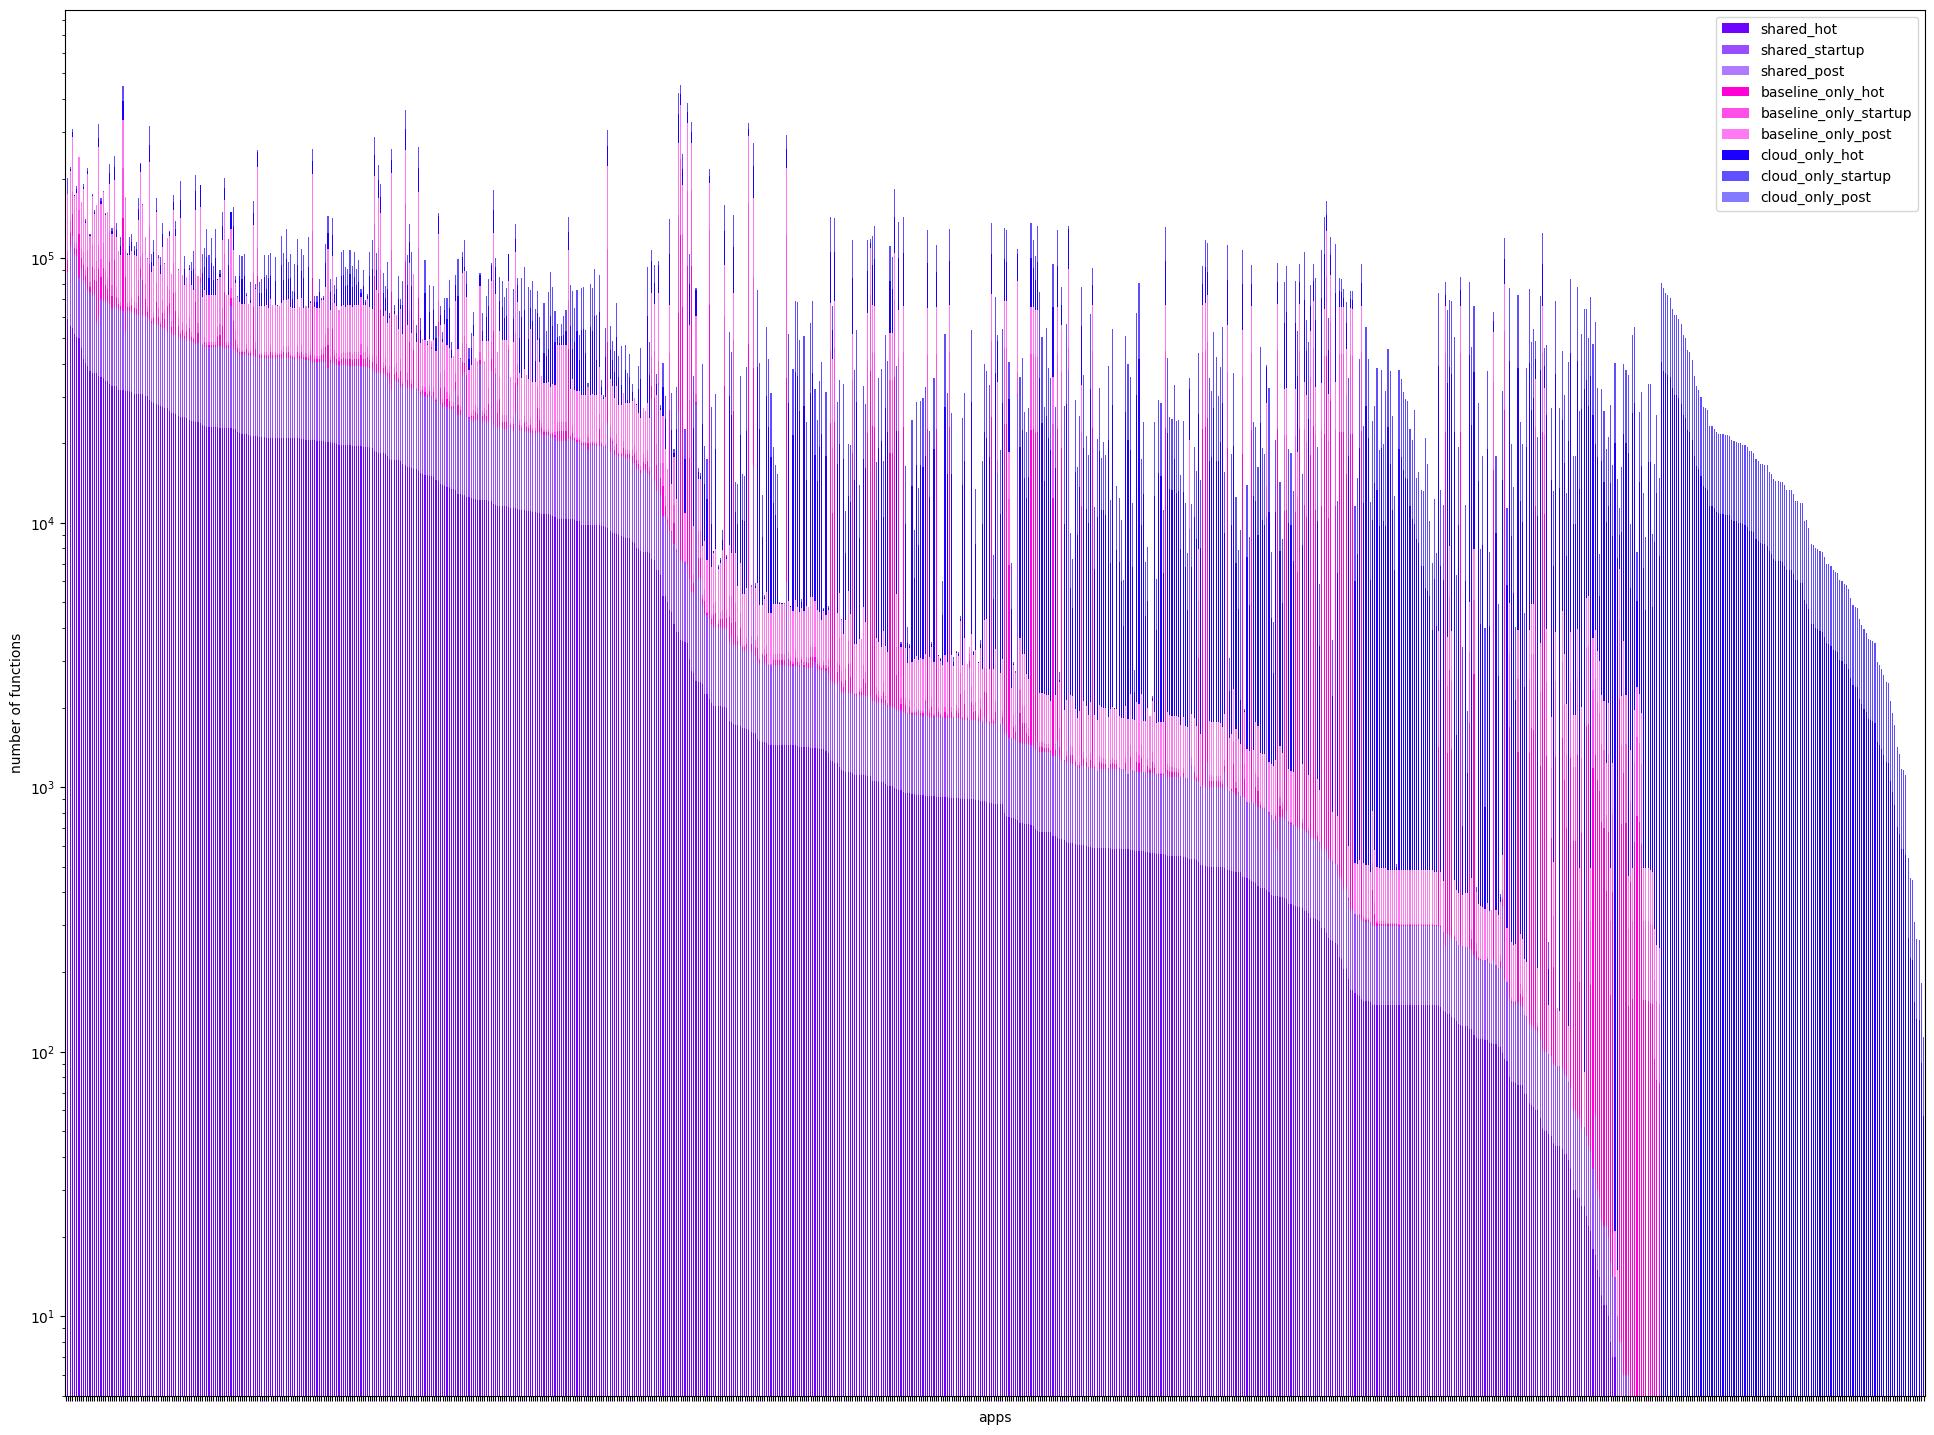

In [10]:
def bad_plot(df,name="bad_plot.pdf"):
    cols = ['shared_hot', 'shared_startup', 'shared_post',
                   'baseline_only_hot', 'baseline_only_startup', 'baseline_only_post', 
                   'cloud_only_hot', 'cloud_only_startup', 'cloud_only_post']
    df = df[cols]
    df = df.sort_values(by=cols, ascending=False)
    ax = df.plot.bar(stacked=True, logy=True, figsize=(24,18), color=["#6E01FF", "#984EFF", "#B07AFF", "#FF00D6", "#FF4FE8", "#FF7AF2", "#1B00FF", "#5F4FFF", "#847AFF"])

    ax.set_xticklabels([])

    ax.set_xlabel("apps")
    ax.set_ylabel("number of functions")

    fig = ax.get_figure()
    fig.savefig(name)

bad_plot(df_plotable)

In [11]:
any_methods = df_plotable[["shared_any", "baseline_only_any", "cloud_only_any"]]
any_methods

,shared_any,baseline_only_any,cloud_only_any
com.ForgeGames.SpecialForcesGroup2,0,0,5924
com.bitstrips.imoji,413,13,5979
com.callapp.contacts,7824,1753,32176
com.playgendary.sportmasters,42,1336,37573
cn.wps.moffice_eng,13798,2120,11853
...,...,...,...
com.threed.bowling,0,0,1977
com.google.android.deskclock,468,43,6470
com.fundevs.app.mediaconverter,0,0,8566
com.springwalk.mediaconverter,587,73,11220


In [12]:
print(f"apps with no methods in the cloud profile:    {len(any_methods[any_methods['cloud_only_any'] == 0])}")
print(f"apps with no methods in the baseline profile: {len(any_methods[any_methods['baseline_only_any'] == 0])}")

apps with no methods in the cloud profile:    110
apps with no methods in the baseline profile: 128


for the top 400 this was:

- apps with no methods in the cloud profile:    27
- apps with no methods in the baseline profile: 141